<h1>Problem statement</h1>

<h2> Governing equations </h2>
<h4> Continuity equation: </h4>
<br>
<br>$$\frac{\partial u}{\partial x}+\frac{\partial w}{\partial z}=0$$<br>
<h4> Momentum conservation in x direction: </h4>
<br>
$$u\frac{\partial u}{\partial x}+w\frac{\partial u}{\partial z}
= \frac{-1}{\rho} \frac{\partial p}{\partial x} + \nu_{total}(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial z^2})$$<br>
<h4> Momentum conservation in z direction: </h4>
<br>
$$u\frac{\partial w}{\partial x}+w\frac{\partial w}{\partial z}
= \frac{-1}{\rho} \frac{\partial p}{\partial z} + \nu_{total}(\frac{\partial^2 w}{\partial x^2}+\frac{\partial^2 w}{\partial z^2})$$<br>
<h4> Spalart-Allmaras Turbulence model </h4>
$$U\frac{\partial \tilde{\nu}}{\partial x}+V\frac{\partial \tilde{\nu}}{\partial z} = 
C_{b1}\tilde{S}\tilde{\nu}-C_{w1}f_{w}(\frac{\tilde{\nu}}{d})^2+
\frac{1}{\sigma}[\frac{\partial (\nu+\tilde{\nu})}{\partial x}\frac{\partial \tilde{\nu}}{\partial x}+
\frac{\partial (\nu+\tilde{\nu})}{\partial z}\frac{\partial \tilde{\nu}}{\partial z}]+
C_{b2}[\frac{\partial \tilde{\nu}}{\partial x}\frac{\partial \tilde{\nu}}{\partial x}+
\frac{\partial \tilde{\nu}}{\partial z}\frac{\partial \tilde{\nu}}{\partial z}]$$
where d is the distance to the closest wall, i.e. d = z
<br>
<br>
<!-- SA formulas -->
$\nu_{t} = \tilde{\nu}f_{v1}$;&nbsp;&nbsp;&nbsp;$f_{v1} = \frac{X^3}{X^3+(C_{v1})^3}$;&nbsp;&nbsp;&nbsp;$X = \frac{\tilde{\nu}}{\nu}$;&nbsp;&nbsp;&nbsp;$\tilde{S} = S + \frac{\tilde{\nu}}{k^2d^2}f_{v2}$;&nbsp;&nbsp;&nbsp;
$f_{v2} = 1 - \frac{X}{1+Xf_{v1}}$;&nbsp;&nbsp;&nbsp;$f_{w} = g[\frac{1+(C_{w3})^6}{g^6+(C_{w3})^6}]^{\frac{1}{6}}$;&nbsp;&nbsp;&nbsp;$g = r + C_{w2}(r^6-r)$;&nbsp;&nbsp;&nbsp;$r = \frac{\tilde{\nu}}{\tilde{S}k^2d^2}$;&nbsp;&nbsp;&nbsp;$\sqrt{2\omega_{ij}\omega_{ij}}$;&nbsp;&nbsp;&nbsp;$\omega_{ij} = \frac{1}{2}(\frac{\partial V}{\partial z}-\frac{\partial U}{\partial x})$
<!-- SA formulas -->
<br>
<br>
$\sigma = \frac{2}{3}$
<br>
$C_{b1} = 0.1355$
<br>
$C_{b2} = 0.622$
<br>
$k = 0.41$
<br>
$C_{w1} = \frac{C_{b1}}{k^2} + \frac{1 + C_{b2}}{\sigma^2} = 4.4556$
<br>
$C_{w2} = 0.3$
<br>
$C_{w3} = 2$
<br>
$C_{v1} = 7.1$

<h2>Loss function</h2>
$$ Loss_{total} = \lambda_1 Loss_{BC} + \lambda_2 Loss_{RANS} + \lambda_3 Loss_{sample}$$

Missing viscosity $\nu$ value?
<br>
Time averaged viscosity?
<br>
Correct $\omega_{ij}$ formula?

<h2> Boundary condition </h2>
<h4> No-slip condition: </h4>
$$ u(x,0) = 0 $$
<h4> Impermeability </h4>
$$ w(x,0) = 0 $$
As $\tilde{\nu}$ is modelled to vary linearly with $y^{+}$, thus at the wall
$$ \tilde{\nu} = 0 $$
<h4> Inlet velocity specification</h4>
<h4> Outlet velocity specification</h4>

<h2> Assumptions </h2>
density set to average

In [1]:
import torch
from torch import nn
from torch import autograd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from pyDOE import lhs         #Latin Hypercube Sampling

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
# np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


# Data explore

In [2]:
df = pd.read_csv("../Data/flatplate_SA.csv")
df.head()

,x,z,Density,Nu_Tilde,Pressure,Temperature,U,W,dUdX,dWdX,dUdZ,dWdZ,d2UdX2,d2WdZ2,dNu_tdX,dNu_tdZ
0,-0.33333,1.000000,1.32904,0.000042,114458,300.011,69.3978,1.506060e-02,-0.108031,0.164869,0.018487,0.057298,0.063200,0.144602,2.026700e-08,1.221950e-09
1,-0.33333,0.000000,1.32916,0.000042,114472,300.021,69.3722,-4.676130e-08,-0.037329,0.000001,0.542601,-0.054418,-0.644586,1948.480000,7.022550e-07,1.028290e-06
2,-0.33333,0.783489,1.32906,0.000042,114460,300.013,69.3938,2.654990e-03,-0.040965,0.129888,0.026876,0.025990,-0.040836,0.147547,9.383690e-09,9.237080e-10
3,-0.33333,0.613855,1.32908,0.000042,114463,300.015,69.3883,1.734410e-03,-0.004336,0.124765,0.031603,0.000633,0.043214,0.078464,8.155600e-09,5.857300e-10
4,-0.33333,0.480948,1.32910,0.000042,114465,300.016,69.3841,2.069920e-03,0.004464,0.133878,0.033287,-0.003579,0.105491,0.013416,7.786610e-09,-6.457530e-11


In [3]:
df.shape

(3381, 16)

In [4]:
## Coordinates
x = torch.tensor(df["x"]).view(-1,1)
z = torch.tensor(df["z"]).view(-1,1)
U = torch.tensor(df["U"]).view(-1,1)
W = torch.tensor(df["W"]).view(-1,1)
P = torch.tensor(df["Pressure"]).view(-1,1)
Nu_tilde = torch.tensor(df["Nu_Tilde"]).view(-1,1)

Rho = torch.tensor(df["Density"]).view(-1,1)

<h2>Data visualisation</h2>

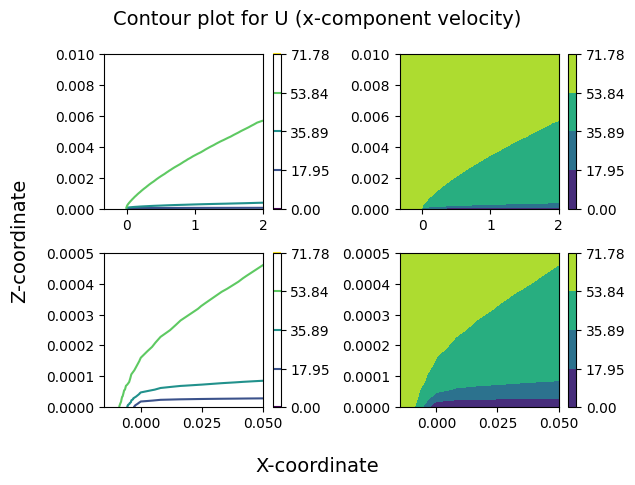

In [5]:
fig, ax = plt.subplots(2,2)
cmap_U = []
levels_U = np.linspace(torch.min(U),torch.max(U),5) # Contour levels

# Overview
cmap_U.append(ax[0,0].tricontour(x.squeeze(),z.squeeze(),U.squeeze(),levels=levels_U))
ax[0,0].set_ylim([0,0.01])
cmap_U.append(ax[0,1].tricontourf(x.squeeze(),z.squeeze(),U.squeeze(),levels=levels_U))
ax[0,1].set_ylim([0,0.01])

# Boundary layer initiation (zoomed in version)
cmap_U.append(ax[1,0].tricontour(x.squeeze(),z.squeeze(),U.squeeze(),levels=levels_U))
ax[1,0].set_xlim([-0.015,0.05])
ax[1,0].set_ylim([0,0.0005])

cmap_U.append(ax[1,1].tricontourf(x.squeeze(),z.squeeze(),U.squeeze(),levels=levels_U))
ax[1,1].set_xlim([-0.015,0.05])
ax[1,1].set_ylim([0,0.0005])

# Figure format
fig.suptitle("Contour plot for U (x-component velocity)",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
for i in range(len(cmap_U)):
    fig.colorbar(cmap_U[i],ticks=levels_U)
fig.tight_layout()
plt.show()

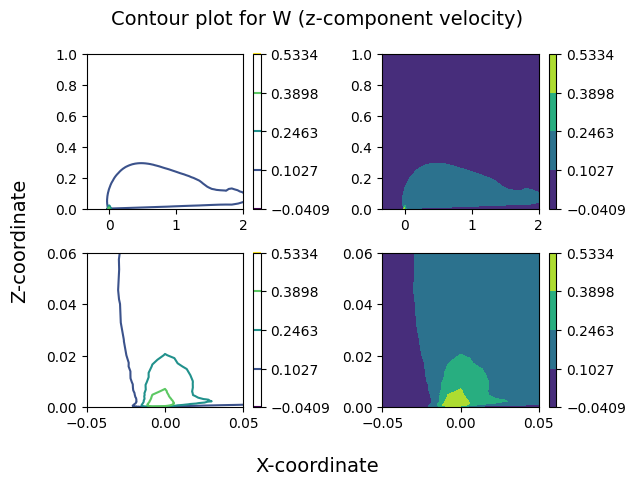

In [6]:
fig, ax = plt.subplots(2,2)
cmap_W = []
levels_W = np.linspace(torch.min(W),torch.max(W),5) # Contour levels

# Overview
cmap_W.append(ax[0,0].tricontour(x.squeeze(),z.squeeze(),W.squeeze(),levels=levels_W))
cmap_W.append(ax[0,1].tricontourf(x.squeeze(),z.squeeze(),W.squeeze(),levels=levels_W))

# Boundary layer initiation (zoomed in version)
cmap_W.append(ax[1,0].tricontour(x.squeeze(),z.squeeze(),W.squeeze(),levels=levels_W))
ax[1,0].set_xlim([-0.05,0.05])
ax[1,0].set_ylim([0,0.06])

cmap_W.append(ax[1,1].tricontourf(x.squeeze(),z.squeeze(),W.squeeze(),levels=levels_W))
ax[1,1].set_xlim([-0.05,0.05])
ax[1,1].set_ylim([0,0.06])

# Figure format
fig.suptitle("Contour plot for W (z-component velocity)",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
for i in range(len(cmap_W)):
    fig.colorbar(cmap_W[i],ticks=levels_W)
fig.tight_layout()
plt.show()

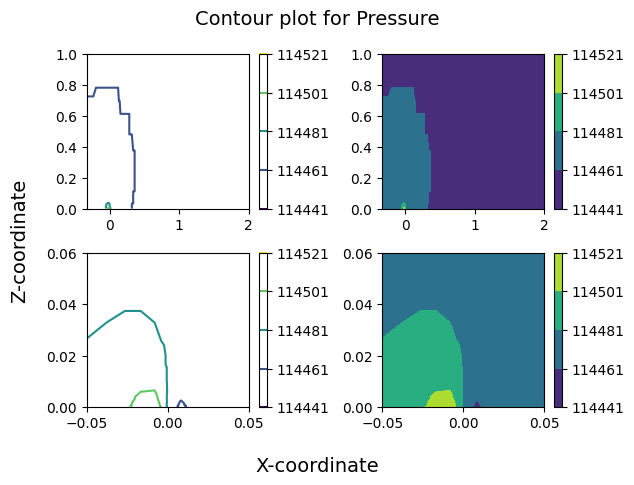

In [7]:
fig, ax = plt.subplots(2,2)
cmap_P = []
levels_P = np.linspace(torch.min(P),torch.max(P),5) # Contour levels


# Overview
cmap_P.append(ax[0,0].tricontour(x.squeeze(),z.squeeze(),P.squeeze(),levels=levels_P))
cmap_P.append(ax[0,1].tricontourf(x.squeeze(),z.squeeze(),P.squeeze(),levels=levels_P))

# Boundary layer initiation (zoomed in version)
cmap_P.append(ax[1,0].tricontour(x.squeeze(),z.squeeze(),P.squeeze(),levels=levels_P))
ax[1,0].set_xlim([-0.05,0.05])
ax[1,0].set_ylim([0,0.06])

cmap_P.append(ax[1,1].tricontourf(x.squeeze(),z.squeeze(),P.squeeze(),levels=levels_P))
ax[1,1].set_xlim([-0.05,0.05])
ax[1,1].set_ylim([0,0.06])

# Figure format
fig.suptitle("Contour plot for Pressure",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
for i in range(len(cmap_P)):
    fig.colorbar(cmap_P[i],ticks=levels_P)
fig.tight_layout()
plt.show()

# Feature engineering

<h2> Parameters </h2>

In [8]:
# Sampling
N_BC = 100
N_RANS = 1000
N_sample = 400

# PINN
layers = [2,32,64,64,32,4]
lr = 1e-4
steps=10000
iterations = 10000 # Adam

# Governing equation
density = np.average(Rho)
nu_laminar = 1.562e-5
U_ref = 100
# Spalart-Allmaras turbullence model
sigma = 2/3
C_b1 = 0.1355
C_b2 = 0.622
k = 0.41
C_w1 = C_b1/k**2  + (1+C_b2)/sigma**2
C_w2 = 0.3
C_w3 = 2
C_nu1 = 7.1

print("Density : ",density)
print("Cw1 : ",C_w1)

Density :  1.3260787222715171
Cw1 :  4.455567816775728


<h2> Spalart-Allmarus turbulence model</h2>

In [9]:
# Wall function
chi = lambda nu_tilde : nu_tilde/nu_laminar 
f_v1 = lambda nu_tilde : chi(nu_tilde)**3 / (chi(nu_tilde)**3 + C_nu1**3)
nu_tilde_to_eddy = lambda nu_tilde : nu_tilde*f_v1(nu_tilde)
Nu_eddy = nu_tilde_to_eddy(Nu_tilde)

print("Nu_eddy shape",Nu_eddy.shape)

Nu_eddy shape torch.Size([3381, 1])


<h2> Test set </h2>

In [10]:
# All data available
x_test = torch.hstack([x,z]) # The coordinates
y_test = torch.hstack([U,W,P,Nu_tilde]) # Flow parameters

<h2>Feature scaling</h2>

In [11]:
class TorchStandardScaler():
    def __init__(self):
        self.mean = 0
        self.sd = 0
        self.fitted = False
        
    def fit(self,input_tensor):
        self.mean = torch.mean(input_tensor,0)
        self.std = torch.std(input_tensor,0)
        
    def transform(self,input_tensor):
        return (input_tensor-self.mean)/self.std
    
    def inverse_transform(self,input_tensor):
        return input_tensor*self.std+self.mean

In [12]:
scaler = TorchStandardScaler()
scaler.fit(y_test)
y_test = scaler.transform(y_test)

In [13]:
# Domain range
x_lb,x_ub,z_lb,z_ub = torch.min(x_test[:,0]),torch.max(x_test[:,0]),torch.min(x_test[:,1]),torch.max(x_test[:,1])
# Velocity range
U_lb,U_ub,W_lb,W_ub = torch.min(y_test[:,0]),torch.max(y_test[:,0]),torch.min(y_test[:,1]),torch.max(y_test[:,1])
P_lb,P_ub,Nu_lb,Nu_ub = torch.min(y_test[:,2]),torch.max(y_test[:,2]),torch.min(y_test[:,3]),torch.max(y_test[:,3])

print("minimum x-coordinate : ",x_lb.numpy(),"maximum x-coordinate : ",x_ub.numpy())
print("minimum z-coordinate : ",z_lb.numpy(),"maximum z-coordinate : ",z_ub.numpy())
print("minimum U (x-coordinate velocity) : ",U_lb.numpy(),"maximum U (x-coordinate velocity) : ",U_ub.numpy())
print("minimum W (z-coordinate velocity) : ",W_lb.numpy(),"maximum W (z-coordinate velocity) : ",W_ub.numpy())
print("minimum P : ",P_lb.numpy(),"maximum P : ",P_ub.numpy())
print("minimum Nu_t : ",Nu_lb.numpy(),"maximum Nu : ",Nu_ub.numpy())

minimum x-coordinate :  -0.33333 maximum x-coordinate :  2.0
minimum z-coordinate :  0.0 maximum z-coordinate :  1.0
minimum U (x-coordinate velocity) :  -2.4448883237357104 maximum U (x-coordinate velocity) :  0.8360613216686013
minimum W (z-coordinate velocity) :  -1.3354264707202335 maximum W (z-coordinate velocity) :  6.078388338573489
minimum P :  -1.8408875099889461 maximum P :  5.007466207008844
minimum Nu_t :  -0.4529115205039708 maximum Nu :  6.843368956551564


In [14]:
torch.min(torch.abs(y_test[:,0]))

tensor(0.0010, dtype=torch.float64)

# Train set

In [15]:
## Note testing set is unscaled 
# Boundary condition

# At the wall
wall_mask = (x_test[:,0]>=0).numpy() & (x_test[:,1]==z_lb).numpy() # x >= 0 and z = 0
x_train_wall = x_test[wall_mask]
y_train_wall = y_test[wall_mask]
print("x_train_wall shape : ",x_train_wall.shape,"y_train_wall shape : ",y_train_wall.shape)

# Inlet
inlet_mask = (x_test[:,0]==x_lb).numpy() # x = -0.333
x_train_inlet = x_test[inlet_mask]
y_train_inlet = y_test[inlet_mask]
print("x_train_inlet shape : ",x_train_inlet.shape,"y_train_inlet shape : ",y_train_inlet.shape)

# Outlet
outlet_mask = (x_test[:,0]==x_ub).numpy() | (x_test[:,1]==z_ub).numpy() # x = 2 and z = 1
x_train_outlet = x_test[outlet_mask]
y_train_outlet = y_test[outlet_mask]
print("x_train_outlet shape : ",x_train_outlet.shape,"y_train_outlet shape : ",y_train_outlet.shape)

# Boundary condition data set
x_train_BC = torch.vstack([x_train_wall,x_train_inlet,x_train_outlet])
y_train_BC = torch.vstack([y_train_wall,y_train_inlet,y_train_outlet])
# Shuffling
idx_BC = np.random.choice(x_train_BC.shape[0],size=N_BC,replace=False)
x_train_BC = x_train_BC[idx_BC,:]
y_train_BC = y_train_BC[idx_BC,:]
print("x_train_BC shape : ",x_train_BC.shape,"y_train_BC shape : ",y_train_BC.shape)

# Collocation points (Full RANS equation)
lower_bound = torch.hstack([x_lb,z_lb])
upper_bound = torch.hstack([x_ub,z_ub])
x_train_RANS = lower_bound + (upper_bound-lower_bound)*lhs(2,samples=N_RANS)
x_train_RANS = torch.vstack([x_train_RANS,x_train_BC])
print("x_train_RANS shape : ",x_train_RANS.shape)

# Sample points from dataset
idx_sample = np.random.choice(x_test.shape[0],size=N_sample,replace=False)
x_train_sample = x_test[idx_sample,:]
y_train_sample = y_test[idx_sample,:]
print("x_train_sample shape : ",x_train_sample.shape,"y_train_sample shape : ",y_train_sample.shape)

x_train_wall shape :  torch.Size([57, 2]) y_train_wall shape :  torch.Size([57, 4])
x_train_inlet shape :  torch.Size([49, 2]) y_train_inlet shape :  torch.Size([49, 4])
x_train_outlet shape :  torch.Size([117, 2]) y_train_outlet shape :  torch.Size([117, 4])
x_train_BC shape :  torch.Size([100, 2]) y_train_BC shape :  torch.Size([100, 4])
x_train_RANS shape :  torch.Size([1100, 2])
x_train_sample shape :  torch.Size([400, 2]) y_train_sample shape :  torch.Size([400, 4])


<h2> Load data to GPU </h2>

In [16]:
# Boundary condition
X_train_BC = (x_train_BC).float().to(device)
Y_train_BC = (y_train_BC).float().to(device)

# Internal sampling
X_train_sample = (x_train_sample).float().to(device)
Y_train_sample = (y_train_sample).float().to(device)

# Governing equation (RANS equation)
X_train_RANS = (x_train_RANS).float().to(device)
RANS_hat = torch.zeros(X_train_RANS.shape[0],1).float().to(device) # Zero

# Testing
X_test = (x_test).to(device)
Y_test = (y_test).float().to(device)

print("RANS_hat shape : ",RANS_hat.shape)

RANS_hat shape :  torch.Size([1100, 1])


# Machine learning model

<h2> Physics Informed Neural Network </h2>

In [17]:
class PINN(nn.Module):
    def __init__(self,layers):
        super().__init__() # initialising the parent class
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction="mean")
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        # Weight and bias initalisation
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data,gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data) # All bias set to zero
            
    # Forward passes
    def forward(self,x):
        if torch.is_tensor(x) != True:
            a = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        
        # learned features
        a = self.linears[-1](a) # no activation function
        return a
    
    # Boundary condition
    def loss_inlet(self,x_inlet,y_inlet):
        g = x_inlet.clone()
        g.requires_grad = True
        f_raw = self.forward(g)
        f = f_raw
        
        f = scaler.inverse_transform(f_raw)
        y_inlet = scaler.inverse_transform(y_inlet)

        loss_inlet_velocity_u = self.loss_function(f[:,0],y_inlet[:,0])
        loss_inlet_velocity_v = self.loss_function(f[:,1],y_inlet[:,1])
        
        return loss_inlet_velocity_u + loss_inlet_velocity_v


    def loss_outlet(self,x_outlet,y_outlet):
        f_raw = self.forward(x_outlet)
        f = f_raw
        
        f = scaler.inverse_transform(f_raw)
        y_outlet = scaler.inverse_transform(y_outlet)
        
        loss_outlet_velocity_u = self.loss_function(f[:,0],y_outlet[:,0])
        loss_outlet_velocity_v = self.loss_function(f[:,1],y_outlet[:,1])
        
        return loss_outlet_velocity_u + loss_outlet_velocity_v
    
    def loss_wall(self,x_wall,y_wall):
        g = x_wall.clone()
        g.requires_grad = True
        f_raw = self.forward(g)
        # f = f_raw

        # zeros = torch.zeros_like(y_wall).float().to(device)
        # scaled_zeros = scaler.transform(zeros).float().to(device)
        f = scaler.inverse_transform(f_raw).float().to(device)
        y_wall = scaler.inverse_transform(y_wall).float().to(device)
        zeros = (torch.ones([f.shape[0]])*0).float().to(device)
        
        # P_xz = autograd.grad(f[:,2][:,None],g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        # P_z = P_xz[:,[1]]
        # loss_normal_pressure_gradient = self.loss_function(P_z.double(),ones[:,None])
        
        # loss_no_slip_x = self.loss_function(f[:,0],scaled_zeros[:,0])
        # loss_no_slip_z = self.loss_function(f[:,1],scaled_zeros[:,1])
        # loss_wall_viscosity_tilde = self.loss_function(f[:,3],scaled_zeros[:,3])
        loss_no_slip_x = self.loss_function(f[:,0],zeros)
        loss_no_slip_z = self.loss_function(f[:,1],zeros)
        loss_wall_viscosity_tilde = self.loss_function(f[:,3],zeros)
        
        
        return loss_no_slip_x + loss_no_slip_z + loss_wall_viscosity_tilde# + loss_normal_pressure_gradient
    
    # Governing equation
    def loss_turbulent(self, x_turbulent):
        g = x_turbulent.clone()
        g.requires_grad = True
        f_raw = self.forward(g)
        f = (scaler.inverse_transform(f_raw))
        U_xz = autograd.grad(f[:,0][:,None],g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        U_xx_zz = autograd.grad(U_xz,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        U_x = U_xz[:,[0]]
        U_z = U_xz[:,[1]]
        U_xx = U_xx_zz[:,[0]]
        U_zz = U_xx_zz[:,[1]]
        W_xz = autograd.grad(f[:,1][:,None],g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        W_xx_zz = autograd.grad(W_xz,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        W_x = W_xz[:,[0]]
        W_z = W_xz[:,[1]]      
        W_xx = W_xx_zz[:,[0]]
        W_zz = W_xx_zz[:,[1]]
        P_xz = autograd.grad(f[:,2][:,None],g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        P_x = P_xz[:,[0]]
        P_z = P_xz[:,[1]]        
        
        nu_eddy = nu_tilde_to_eddy(f[:,[3]])
        nu = nu_eddy + nu_laminar

        Nu_tilde_xz = autograd.grad(f[:,3][:,None],g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        Nu_eddy_xz = autograd.grad(nu_eddy,g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        Nu_tilde_x = Nu_tilde_xz[:,[0]]
        Nu_tilde_z = Nu_tilde_xz[:,[1]]
        Nu_eddy_x = Nu_eddy_xz[:,[0]]
        Nu_eddy_z = Nu_eddy_xz[:,[1]]

        # Spalart-Allmarus
        nu_tilde = f[:,[3]].float()
        f_v2 = 1 - chi(nu_tilde)/(1+chi(nu_tilde)*f_v1(nu_tilde))
        d = g[:,[1]]
        omega = 0.5 * (U_z - W_x)
        S = torch.sqrt(2*omega*omega)
        S_tilde = S + nu_tilde/(k**2*d**2)*f_v2
        r = nu_tilde/(S_tilde*k**2*d**2)
        g_SA = r + C_w2*(r**6-r)
        f_w = g_SA * ((1+C_w3**6)/(g_SA**6+C_w3**6))**(1/6)
        
        #################### Spallart-Allmarus model #######################
        RANS_SA = (f[:,[0]].float()*Nu_tilde_x + f[:,[1]].float()*Nu_tilde_z 
                   - C_b1*S_tilde*nu_tilde
                   + C_w1*f_w*(nu_tilde/d)**2
                   - 1/sigma*((Nu_eddy_x+Nu_tilde_x)*Nu_tilde_x + (Nu_eddy_z+Nu_tilde_z)*Nu_tilde_z)
                   - C_b2*(Nu_tilde_x*Nu_tilde_x+Nu_tilde_z*Nu_tilde_z))
        #################### Spallart-Allmarus model #######################
        
        zeros = torch.zeros(RANS_SA.shape[0],1).to(device)
        
        loss_SA = self.loss_function(RANS_SA,zeros) 
    
        return loss_SA
        
    def loss_RANS(self, x_RANS):
        g = x_RANS.clone()
        g.requires_grad = True
        f_raw = self.forward(g)
        # f = f_raw
        
        f = (scaler.inverse_transform(f_raw))
        U_xz = autograd.grad(f[:,0][:,None],g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        U_xx_zz = autograd.grad(U_xz,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        U_x = U_xz[:,[0]]
        U_z = U_xz[:,[1]]
        U_xx = U_xx_zz[:,[0]]
        U_zz = U_xx_zz[:,[1]]
        W_xz = autograd.grad(f[:,1][:,None],g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        W_xx_zz = autograd.grad(W_xz,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        W_x = W_xz[:,[0]]
        W_z = W_xz[:,[1]]      
        W_xx = W_xx_zz[:,[0]]
        W_zz = W_xx_zz[:,[1]]
        P_xz = autograd.grad(f[:,2][:,None],g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        P_x = P_xz[:,[0]]
        P_z = P_xz[:,[1]]
   
        nu_eddy = nu_tilde_to_eddy(f[:,[3]])
        nu = nu_eddy + nu_laminar
        
        #################### RANS #######################
        RANS_continuity = U_x + W_z
        
        RANS_momentum_x = ((f[:,[0]].float()*U_x + f[:,[1]].float()*U_z 
                           + 1/(density)*P_x - nu.float()*(U_xx+U_zz)))
        
        RANS_momentum_z = ((f[:,[0]].float()*W_x + f[:,[1]].float()*W_z 
                            + 1/(density)*P_z - nu.float()*(W_xx+W_zz)))
        #################### RANS #######################
        
        lambda_continuity, lambda_x, lambda_z = 1e3, 1, 1
        loss_continuity = self.loss_function(RANS_continuity,RANS_hat)
        loss_momentum_x = self.loss_function(RANS_momentum_x,RANS_hat)
        loss_momentum_z = self.loss_function(RANS_momentum_z,RANS_hat)
        
        return loss_continuity*lambda_continuity + loss_momentum_x*lambda_x + loss_momentum_z*lambda_z
    
    # Sample points
    def loss_sample(self,x_train_sample,y_train_sample):
        f_raw = self.forward(x_train_sample)
        f = f_raw
        
        f = scaler.inverse_transform(f_raw)
        y_train_sample = scaler.inverse_transform(y_train_sample)
        
        loss_sampling = self.loss_function(f,y_train_sample)
        
        return loss_sampling
    
    # Boundary condition (wrapper function)
    def loss_BC(self,x_PINN_wall,y_PINN_wall,x_PINN_inlet,y_PINN_inlet,x_PINN_outlet,y_PINN_outlet):
        return self.loss_wall(x_PINN_wall,y_PINN_wall) + self.loss_inlet(x_PINN_inlet,y_PINN_inlet) + self.loss_outlet(x_PINN_outlet,y_PINN_outlet)
    
    def loss(self,mode,x_train_BC,y_train_BC,x_train_RANS,x_train_sample,y_train_sample):
        # At wall
        wall_mask = (x_train_BC[:,0]>=0).numpy() & (x_train_BC[:,1]==z_lb).numpy() # x >= 0 and z = 0
        x_PINN_wall = x_train_BC[wall_mask]
        y_PINN_wall = y_train_BC[wall_mask]
        # print(scaler.inverse_transform(y_PINN_wall))
        
        # At inlet
        inlet_mask = (x_train_BC[:,0]==x_lb).numpy() # x = -0.333
        x_PINN_inlet = x_train_BC[inlet_mask]
        y_PINN_inlet = y_train_BC[inlet_mask]
        
        # At outlet
        outlet_mask = (x_train_BC[:,0]==x_ub).numpy() | (x_train_BC[:,1]==z_ub).numpy() # x = 2 and z = 1
        x_PINN_outlet = x_train_BC[outlet_mask]
        y_PINN_outlet = y_train_BC[outlet_mask]
        
        # Turbulent
        turbulent_mask = (x_train_RANS[:,0]>=0).numpy() & (x_train_RANS[:,1]>0.01).numpy() # So not to create nan from 
        x_PINN_turbulent = x_train_RANS[turbulent_mask]
        
        
        lambda1, lambda2, lambda3, lambda4 = 1e-4, 1e6, 1e0, 1e-1
        # lambda1, lambda2, lambda3, lambda4 = 1, 1, 1, 1

        if mode == 0:
            return (#self.loss_RANS(x_train_RANS)*lambda1
                    # + self.loss_turbulent(x_PINN_turbulent)*lambda2
                    + self.loss_BC(x_PINN_wall,y_PINN_wall,x_PINN_inlet,y_PINN_inlet,x_PINN_outlet,y_PINN_outlet)*lambda3
                    + self.loss_sample(x_train_sample,y_train_sample)*lambda4)
                   # )
        elif mode == 1:
            return (#self.loss_RANS(x_train_RANS)*lambda1
                    # + self.loss_turbulent(x_PINN_turbulent)*lambda2
                    # + self.loss_BC(x_PINN_wall,y_PINN_wall,x_PINN_inlet,y_PINN_inlet,x_PINN_outlet,y_PINN_outlet)*lambda3
                    + self.loss_sample(x_train_sample,y_train_sample)*lambda4)
                   # )
        elif mode == 2:
            return (self.loss_RANS(x_train_RANS)*lambda1
                    # + self.loss_turbulent(x_PINN_turbulent)*lambda2
                    + self.loss_BC(x_PINN_wall,y_PINN_wall,x_PINN_inlet,y_PINN_inlet,x_PINN_outlet,y_PINN_outlet)*lambda3
                    + self.loss_sample(x_train_sample,y_train_sample)*lambda4)
                   # )
        elif mode == 3:
            return (self.loss_RANS(x_train_RANS)*lambda1
                    + self.loss_turbulent(x_PINN_turbulent)*lambda2
                    + self.loss_BC(x_PINN_wall,y_PINN_wall,x_PINN_inlet,y_PINN_inlet,x_PINN_outlet,y_PINN_outlet)*lambda3
                    + self.loss_sample(x_train_sample,y_train_sample)*lambda4)
                   # )
        elif mode == 4:
            return (#self.loss_RANS(x_train_RANS)*lambda1
                    + self.loss_turbulent(x_PINN_turbulent)*lambda2
                    # + self.loss_BC(x_PINN_wall,y_PINN_wall,x_PINN_inlet,y_PINN_inlet,x_PINN_outlet,y_PINN_outlet)*lambda3
                    # + self.loss_sample(x_train_sample,y_train_sample)*lambda4)
                   )
        else:
            return 0
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()   
#         
        loss = self.loss(X_train_BC,Y_train_BC,X_train_RANS,X_train_sample,Y_train_sample)
#         
        loss.backward()
        self.iter += 1
        
        if self.iter % 50 == 0:
            test_loss = self.loss_function(scaler.inverse_transform(self.forward(X_test)),scaler.inverse_transform(Y_test))*0.01

        return loss  

<h2> Neural Network summary </h2>

In [18]:
Model = PINN(layers)
Model.float().to(device)
print(Model)

PINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [19]:
Model.loss(0,X_train_BC,Y_train_BC,X_train_RANS,X_train_sample,Y_train_sample)

tensor(2991.5175, dtype=torch.float64, grad_fn=<AddBackward0>)

<h2> Model training </h2>

In [32]:
history = torch.zeros(iterations,2)
optimizer = torch.optim.Adam(Model.parameters(),lr=lr,amsgrad=False)
for i in range(iterations):
    loss = Model.loss(2,X_train_BC,Y_train_BC,X_train_RANS,X_train_sample,Y_train_sample)
    history[i,:] = torch.tensor([i,loss])
    # for linear in Model.linears:
    #     print("Parameters",(linear.weight))
    #     print("Gradient",(linear.weight.grad))
    
    optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(Model.parameters(), 0)
    optimizer.step()
    if i % 250 ==0:
        with torch.no_grad():
            test_loss = Model.loss_function(scaler.inverse_transform(Model(X_test)),scaler.inverse_transform(Y_test))
        print(i,"Training loss :",np.round(loss.detach().cpu().numpy(),3),
              "Testing loss :",np.round(test_loss.detach().cpu().numpy(),2),
             "RANS loss :",np.round(Model.loss_RANS(X_train_RANS).detach().cpu().numpy()*1e-4,4),
             # "Turb loss :",np.round(Model.loss_turbulent(X_train_RANS[(x_train_RANS[:,0]>=0).numpy() & (x_train_RANS[:,1]>0.05).numpy()]).detach().cpu().numpy()*1e10,4),
             "BC loss :",np.round(Model.loss_function(Model(X_train_BC)[:,0:2],Y_train_BC[:,0:2]).detach().cpu().numpy()*1e-1,4),
             "Sample loss :",np.round(Model.loss_sample(X_train_sample,Y_train_sample).detach().cpu().numpy()*1e-1,4))

0 Training loss : 45.492 Testing loss : 158.97 RANS loss : 3.5125 BC loss : 0.054 Sample loss : 17.3496
250 Training loss : 44.55 Testing loss : 102.01 RANS loss : 1.9253 BC loss : 0.0435 Sample loss : 11.3737
500 Training loss : 43.352 Testing loss : 98.71 RANS loss : 1.8715 BC loss : 0.0372 Sample loss : 11.0105
750 Training loss : 42.032 Testing loss : 95.1 RANS loss : 1.8104 BC loss : 0.0318 Sample loss : 10.6156
1000 Training loss : 40.611 Testing loss : 91.28 RANS loss : 1.7309 BC loss : 0.0268 Sample loss : 10.1984
1250 Training loss : 39.121 Testing loss : 87.33 RANS loss : 1.638 BC loss : 0.0226 Sample loss : 9.7661
1500 Training loss : 37.595 Testing loss : 83.32 RANS loss : 1.5303 BC loss : 0.0197 Sample loss : 9.3257
1750 Training loss : 36.128 Testing loss : 79.5 RANS loss : 1.4364 BC loss : 0.0173 Sample loss : 8.9028
2000 Training loss : 34.753 Testing loss : 76.0 RANS loss : 1.3558 BC loss : 0.0157 Sample loss : 8.5122
2250 Training loss : 33.453 Testing loss : 72.74 RA

In [44]:
torch.save(Model.state_dict(), "models/week_unknown.pt")
torch.save(history,"models/week_unknown_epoch.pt")

Text(0, 0.5, 'Training loss')

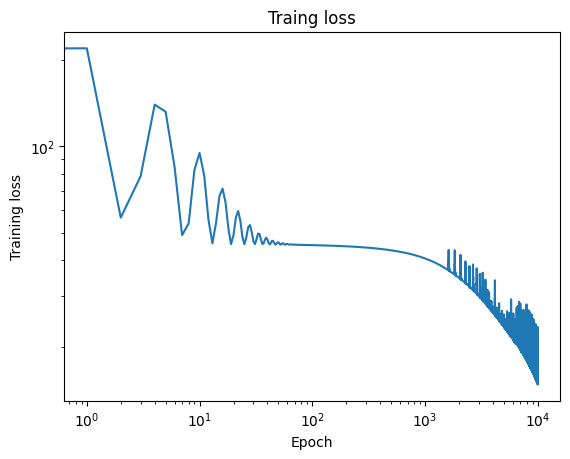

In [33]:
plt.plot(history[:,0],history[:,1])
plt.xscale('log')
plt.yscale('log')
plt.title("Traing loss")
plt.xlabel("Epoch")
plt.ylabel("Training loss")

<h1>Result visualisation</h1>

In [34]:
y_pred = Model(X_test)
y_pred = scaler.inverse_transform(y_pred)

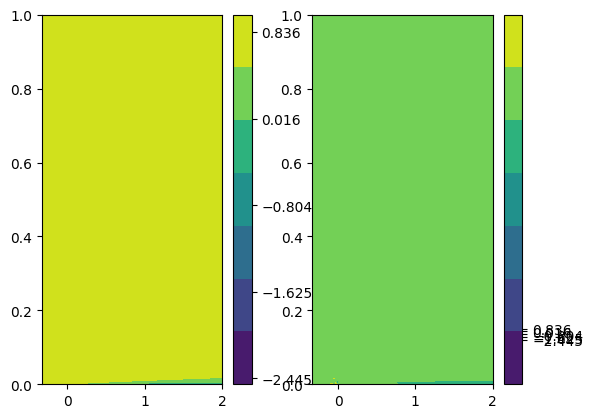

In [46]:
# Full contour plot
fig, ax = plt.subplots(1,2)
levels = np.linspace(torch.min(Y_test[:,0].detach()),torch.max(Y_test[:,0].detach()),5) # Contour levels
cmap_U_pred_full = []

cmap_U_pred_full.append(ax[0].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),Y_test[:,0].detach().numpy()))
cmap_U_pred_full.append(ax[1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,0].detach().numpy()))
for i in range(len(cmap_U_pred_full)):
    fig.colorbar(cmap_U_pred_full[i],ticks=levels)

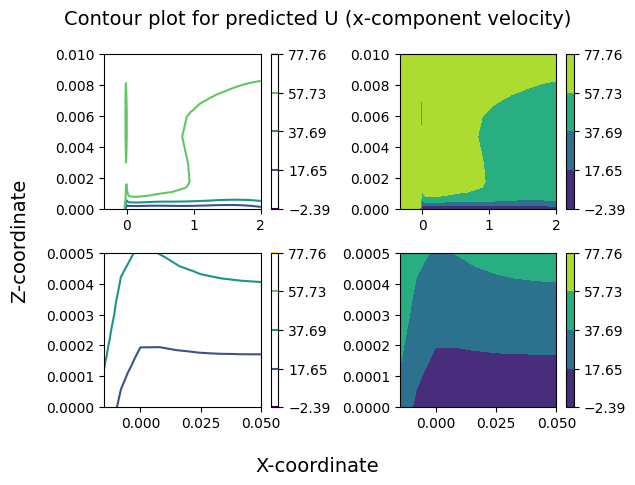

In [36]:
fig, ax = plt.subplots(2,2)
cmap_U_pred = []
levels = np.linspace(torch.min(y_pred[:,0:1].detach()),torch.max(y_pred[:,0:1].detach()),5) # Contour levels

# Overview
cmap_U_pred.append(ax[0,0].tricontour(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,0].detach().numpy(),levels=levels))
ax[0,0].set_ylim([0,0.01])
cmap_U_pred.append(ax[0,1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,0].detach().numpy(),levels=levels))
ax[0,1].set_ylim([0,0.01])

# Boundary layer initiation (zoomed in version)
cmap_U_pred.append(ax[1,0].tricontour(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,0].detach().numpy(),levels=levels))
ax[1,0].set_xlim([-0.015,0.05])
ax[1,0].set_ylim([0,0.0005])

cmap_U_pred.append(ax[1,1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,0].detach().numpy(),levels=levels))
ax[1,1].set_xlim([-0.015,0.05])
ax[1,1].set_ylim([0,0.0005])

# Figure format
fig.suptitle("Contour plot for predicted U (x-component velocity)",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
for i in range(len(cmap_U_pred)):
    fig.colorbar(cmap_U_pred[i],ticks=levels)
fig.tight_layout()
plt.show()

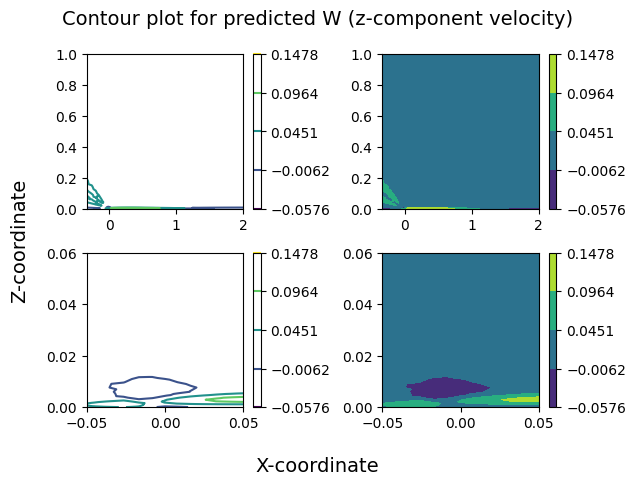

In [37]:
fig, ax = plt.subplots(2,2)
cmap_W_pred = []
levels = np.linspace(torch.min(y_pred[:,1:2].detach()),torch.max(y_pred[:,1:2].detach()),5) # Contour levels

# Overview
cmap_W_pred.append(ax[0,0].tricontour(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,1].detach().numpy(),levels=levels))
ax[0,0].set_ylim([0,1])
cmap_W_pred.append(ax[0,1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,1].detach().numpy(),levels=levels))
ax[0,1].set_ylim([0,1])

# Boundary layer initiation (zoomed in version)
cmap_W_pred.append(ax[1,0].tricontour(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,1].detach().numpy(),levels=levels))
ax[1,0].set_xlim([-0.05,0.05])
ax[1,0].set_ylim([0,0.06])

cmap_W_pred.append(ax[1,1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,1].detach().numpy(),levels=levels))
ax[1,1].set_xlim([-0.05,0.05])
ax[1,1].set_ylim([0,0.06])

# Figure format
fig.suptitle("Contour plot for predicted W (z-component velocity)",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
for i in range(len(cmap_W_pred)):
    fig.colorbar(cmap_W_pred[i],ticks=levels)
fig.tight_layout()
plt.show()

In [38]:
torch.max(y_pred[:,2:3].detach())

tensor(114503.7437, dtype=torch.float64)

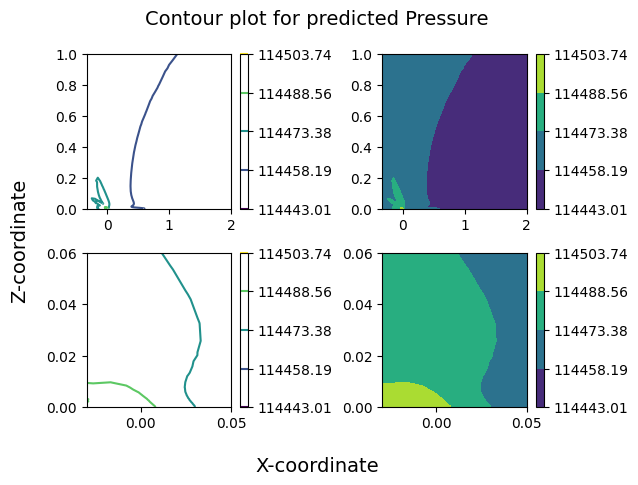

In [39]:
fig, ax = plt.subplots(2,2)
cmap_P_pred = []
levels = np.linspace(torch.min(y_pred[:,2:3].detach()),torch.max(y_pred[:,2:3].detach()),5) # Contour levels

# Overview
cmap_P_pred.append(ax[0,0].tricontour(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,2].detach().numpy(),levels=levels))
ax[0,0].set_ylim([0,1])
cmap_P_pred.append(ax[0,1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,2].detach().numpy(),levels=levels))
ax[0,1].set_ylim([0,1])

# Boundary layer initiation (zoomed in version)
cmap_P_pred.append(ax[1,0].tricontour(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,2].detach().numpy(),levels=levels))
ax[1,0].set_xlim([-0.03,0.05])
ax[1,0].set_ylim([0,0.06])

cmap_P_pred.append(ax[1,1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,2].detach().numpy(),levels=levels))
ax[1,1].set_xlim([-0.03,0.05])
ax[1,1].set_ylim([0,0.06])

# Figure format
fig.suptitle("Contour plot for predicted Pressure",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
for i in range(len(cmap_P_pred)):
    fig.colorbar(cmap_P_pred[i],ticks=levels)
fig.tight_layout()
plt.show()

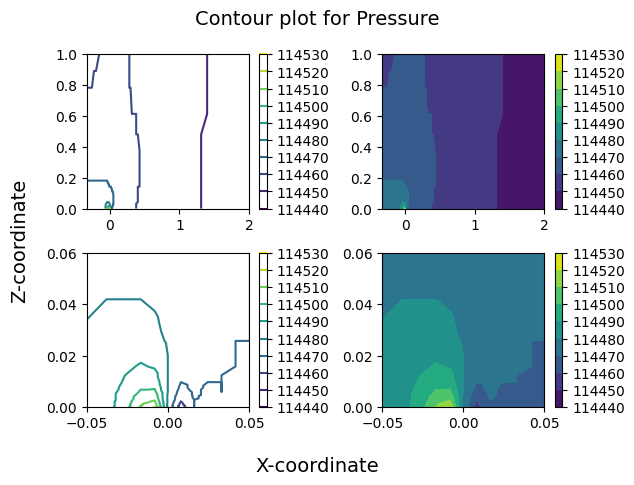

In [40]:
fig, ax = plt.subplots(2,2)
cmap_P = []

# Overview
cmap_P.append(ax[0,0].tricontour(x.squeeze(),z.squeeze(),P.squeeze()))
cmap_P.append(ax[0,1].tricontourf(x.squeeze(),z.squeeze(),P.squeeze()))

# Boundary layer initiation (zoomed in version)
cmap_P.append(ax[1,0].tricontour(x.squeeze(),z.squeeze(),P.squeeze()))
ax[1,0].set_xlim([-0.05,0.05])
ax[1,0].set_ylim([0,0.06])

cmap_P.append(ax[1,1].tricontourf(x.squeeze(),z.squeeze(),P.squeeze()))
ax[1,1].set_xlim([-0.05,0.05])
ax[1,1].set_ylim([0,0.06])

# Figure format
fig.suptitle("Contour plot for Pressure",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
for i in range(len(cmap_P)):
    fig.colorbar(cmap_P[i])
fig.tight_layout()
plt.show()

In [41]:
###########Preparing unseen data############
x1_future = torch.linspace(2,4,200)
x2_future = torch.linspace(0,1,200)

X1_future,X2_future = torch.meshgrid(x1_future,x2_future,indexing='ij')
X_future = torch.hstack([X1_future.reshape(-1,1),X2_future.reshape(-1,1)])

In [42]:
###########Predicting unseen data############
y_pred_future = Model(X_future)
y_pred_future = scaler.inverse_transform(y_pred_future)

(0.0, 0.01)

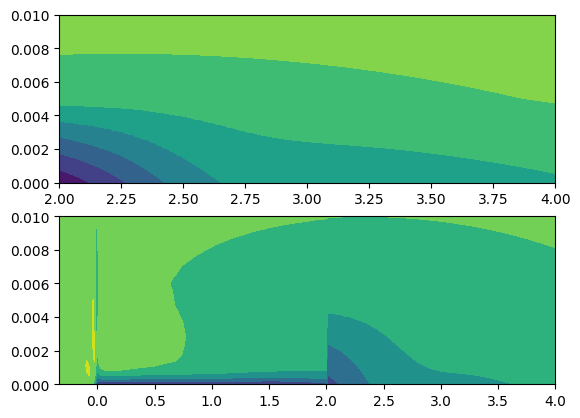

In [43]:
fig, ax = plt.subplots(2,1)
ax[0].tricontourf(X_future[:,0].detach().numpy(),X_future[:,1].detach().numpy(),y_pred_future[:,0].detach().numpy())

X_total = torch.vstack([X_test,X_future])
y_total = torch.vstack([y_pred,y_pred_future])

ax[1].tricontourf(X_total[:,0].detach().numpy(),X_total[:,1].detach().numpy(),y_total[:,0].detach().numpy())
ax[0].set_ylim([0,0.01])
ax[1].set_ylim([0,0.01])